# fgco2 Histogram

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

## Area

In [3]:
variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# combine datasets just to pick first member and it gets naming the way i want
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

### New coords with `dd` and `dd_x`

`A` is area over Pacific and southern ocean. They get `newcoords`


In [4]:
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].sel(y = slice(-80,-30)).areacello
# # A2 = dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello
# # A


# newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords = {'x':A['x'], 'y':A['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 50)>
 array([-79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5])
 Coordinates:
   * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
 Attributes:
     axis:           Y
     bounds:         lat_bnds
     cell_methods:   time: point


## Get datasets and calculate variables

### These datasets are selected over Pacific, southern ocean, and upper 1000m
I load them, reassign their coords to match `dd_A['GFDL-ESM4.gr.historical.Ofx']`, and then calculate `p`, `insitutemp`, `sigma2`, and `sigma0`, '`PCO2`

In [5]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').sel(lev = slice(0, 1000), y = slice(-80,-30))
# A = xr.open_mfdataset('AREA.nc')

In [6]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

In [7]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

In [8]:
dd['CESM2-FV2.gr.historical.Omon']


<xarray.Dataset>
Dimensions:     (y: 50, x: 360, lev: 19)
Coordinates:
  * y           (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
  * x           (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon         (x, y) float64 dask.array<chunksize=(360, 50), meta=np.ndarray>
    lat         (x, y) float64 dask.array<chunksize=(360, 50), meta=np.ndarray>
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 700.0 800.0 900.0 1e+03
Data variables:
    dissic      (lev, y, x) float32 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    fgco2       (y, x) float32 dask.array<chunksize=(50, 360), meta=np.ndarray>
    so          (lev, y, x) float32 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    talk        (lev, y, x) float32 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    thetao      (lev, y, x) float32 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    p           (lev, y, x) float64 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    insitutemp  (lev, y, x) float64 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    sigma2      (lev, y, x) float64 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>
    sigma0      (lev, y, x) float64 dask.array<chunksize=(19, 50, 360), meta=np.ndarray>

## Dictionary for plot colors

In [9]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## Area weighted histogram for `fgco2`


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


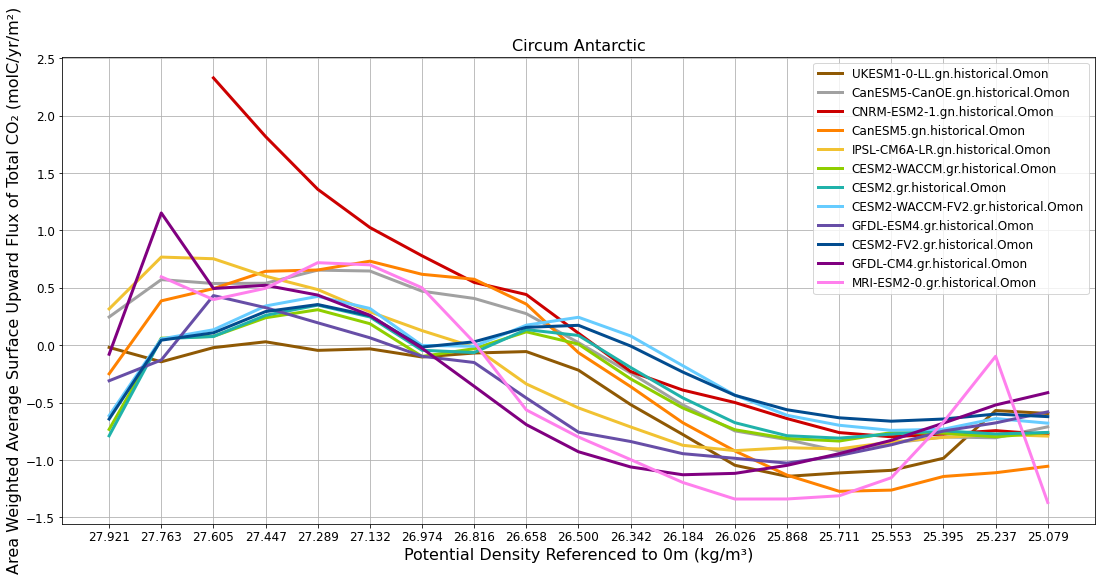

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

target = np.linspace(25, 28, 20)
binz = np.linspace(25, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():

    h2 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = -1*ds.fgco2*A*conversion)
                   # *ds['lev_bounds'].diff('bnds')*A)
    h3 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = A)
    
    hi = h2/h3
    
    hi.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Area Weighted Average Surface Upward Flux of Total CO\u2082 (molC/yr/m\u00b2)', fontsize = 16)
ax.set_title('Circum Antarctic')
ax.set_xticks([25.078947, 25.236842, 25.394737, 25.552632, 25.710526, 25.868421,
       26.026316, 26.184211, 26.342105, 26.5     , 26.657895, 26.815789,
       26.973684, 27.131579, 27.289474, 27.447368, 27.605263, 27.763158,
       27.921053])
ax.grid()
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

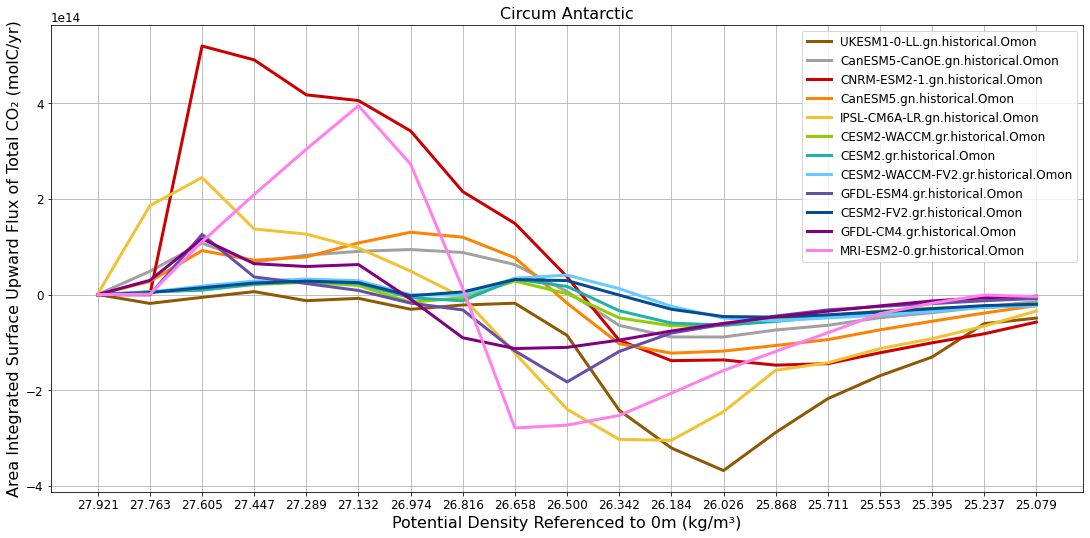

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

target = np.linspace(25, 28, 20)
binz = np.linspace(25, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():

    h2 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = -1*ds.fgco2*A*conversion)
                   # *ds['lev_bounds'].diff('bnds')*A)
    h3 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = A)
    
    hi = h2/h3
    
    h2.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Area Integrated Surface Upward Flux of Total CO\u2082 (molC/yr)', fontsize = 16)
ax.set_title('Circum Antarctic')
ax.set_xticks([25.078947, 25.236842, 25.394737, 25.552632, 25.710526, 25.868421,
       26.026316, 26.184211, 26.342105, 26.5     , 26.657895, 26.815789,
       26.973684, 27.131579, 27.289474, 27.447368, 27.605263, 27.763158,
       27.921053])
ax.grid()
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)